In [1]:
import os
import cv2

# Define paths
base_dir = 'yolo format'
all_files_dir = os.path.join(base_dir, 'obj_train_data')
all_files = os.listdir(all_files_dir)

# Filter images and annotations
all_images = [f for f in all_files if f.endswith('.PNG')]
all_annotations = [f.replace('.PNG', '.txt') for f in all_images]

# Function to parse annotations and get unique classes
def parse_annotations(annotation_file):
    boxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            boxes.append((class_id, x_center, y_center, width, height))
    return boxes
# Get unique classes
unique_classes = sorted(list(set([int(line.split()[0]) for annotation in all_annotations for line in open(os.path.join(all_files_dir, annotation)).readlines()])))
class_names = {i: f'class_{i}' for i in unique_classes}

print("Unique classes found:", class_names)

Unique classes found: {0: 'class_0', 1: 'class_1'}


In [2]:
from sklearn.model_selection import train_test_split

# Create directories for each class
for class_name in class_names.values():
    os.makedirs(os.path.join(base_dir, 'cropped', 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'cropped', 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'cropped', 'test', class_name), exist_ok=True)

# Function to crop images and save them
def crop_and_save_images(images, annotations, src_dir, dst_dir):
    for image, annotation in zip(images, annotations):
        image_path = os.path.join(src_dir, image)
        img = cv2.imread(image_path)
        height, width, _ = img.shape

        boxes = parse_annotations(os.path.join(src_dir, annotation))
        for idx, (class_id, x_center, y_center, box_width, box_height) in enumerate(boxes):
            x_min = int((x_center - box_width / 2) * width)
            x_max = int((x_center + box_width / 2) * width)
            y_min = int((y_center - box_height / 2) * height)
            y_max = int((y_center + box_height / 2) * height)
            
            cropped_img = img[y_min:y_max, x_min:x_max]
            class_name = class_names[class_id]
            save_path = os.path.join(dst_dir, class_name, f'{os.path.splitext(image)[0]}_{idx}.png')
            cv2.imwrite(save_path, cropped_img)
# Split the data
train_images, temp_images, train_annotations, temp_annotations = train_test_split(all_images, all_annotations, test_size=0.4, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(temp_images, temp_annotations, test_size=0.5, random_state=42)

# Crop and save images to respective directories
crop_and_save_images(train_images, train_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'train'))
crop_and_save_images(val_images, val_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'val'))
crop_and_save_images(test_images, test_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'test'))

print('Images cropped and saved successfully!')

Images cropped and saved successfully!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
input_shape = (224, 224, 3)
batch_size = 32

# Data Generators with Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'train'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'val'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4131 images belonging to 2 classes.
Found 1399 images belonging to 2 classes.
Found 1507 images belonging to 2 classes.


In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define input shape and class names
input_shape = (224, 224, 3)  # Example shape, adjust based on your actual input data
class_names = ['class_0', 'class_1']  # Example class names, adjust based on your dataset

# Assuming you have set up your ImageDataGenerator for training, validation, and test data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'yolo format/cropped/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'yolo format/cropped/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'yolo format/cropped/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load Pre-trained GoogLeNet (InceptionV3) Model and Modify It
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_googlenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_googlenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model_googlenet.fit(train_generator, epochs=2, validation_data=val_generator)

# Save the Model
model_googlenet.save('traffic_model_googlenet.h5')

# Evaluate the Model
evaluation_googlenet = model_googlenet.evaluate(test_generator)
print(f'GoogLeNet Test loss: {evaluation_googlenet[0]}, Test accuracy: {evaluation_googlenet[1]}')


Found 4131 images belonging to 2 classes.
Found 1399 images belonging to 2 classes.
Found 1507 images belonging to 2 classes.
Epoch 1/2


C:\Users\barbr\PycharmProjects\CNN_implementation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8938 - loss: 0.4133 - val_accuracy: 0.9650 - val_loss: 0.0992
Epoch 2/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9779 - loss: 0.0647 - val_accuracy: 0.9714 - val_loss: 0.0778


48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9711 - loss: 0.0848
GoogLeNet Test loss: 0.07754143327474594, Test accuracy: 0.9714664816856384


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Parameters
input_shape = (224, 224, 3)
class_names = ['class_0', 'class_1']  # Update this with your actual class names
batch_size = 32  # Adjust according to your GPU memory

# Directories
train_dir = 'yolo format/cropped/train'
val_dir = 'yolo format/cropped/val'
test_dir = 'yolo format/cropped/test'

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load Pre-trained ResNet50 Model and Modify It
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model with Early Stopping
model_resnet.fit(train_generator, epochs=2, validation_data=val_generator, callbacks=[early_stopping])

# Save the Model
model_resnet.save('traffic_model_resnet.h5')

# Evaluate the Model
evaluation_resnet = model_resnet.evaluate(test_generator)
print(f'ResNet Test loss: {evaluation_resnet[0]}, Test accuracy: {evaluation_resnet[1]}')


Found 4131 images belonging to 2 classes.
Found 1399 images belonging to 2 classes.
Found 1507 images belonging to 2 classes.
Epoch 1/2


C:\Users\barbr\PycharmProjects\CNN_implementation\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 568s 4s/step - accuracy: 0.6251 - loss: 0.8340 - val_accuracy: 0.6841 - val_loss: 0.6863
Epoch 2/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.6954 - loss: 0.6097 - val_accuracy: 0.7248 - val_loss: 0.5348


48/48 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4641 - loss: 0.7547
ResNet Test loss: 0.5060473680496216, Test accuracy: 0.7511612772941589


In [3]:
 from tensorflow.keras.applications import MobileNetV2

# Load Pre-trained MobileNetV2 Model and Modify It
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model_mobilenet.fit(train_generator, epochs=2, validation_data=val_generator)

# Save the Model
model_mobilenet.save('traffic_model_mobilenet.h5')

# Evaluate the Model
evaluation_mobilenet = model_mobilenet.evaluate(test_generator)
print(f'MobileNet Test loss: {evaluation_mobilenet[0]}, Test accuracy: {evaluation_mobilenet[1]}')

Epoch 1/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.8578 - loss: 0.7121 - val_accuracy: 0.9685 - val_loss: 0.0763
Epoch 2/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9801 - loss: 0.0529 - val_accuracy: 0.9757 - val_loss: 0.0726


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9860 - loss: 0.0392
MobileNet Test loss: 0.06345240026712418, Test accuracy: 0.9774386286735535


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os  # Import the os module

# Parameters
input_shape = (224, 224, 3)
batch_size = 32

# Data Generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming base_dir is defined earlier in your script
base_dir = 'yolo format'  # Replace with your actual base directory

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1507 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import load_model
import numpy as np

# Load trained models
model_googlenet = load_model('traffic_model_googlenet.h5')
model_resnet = load_model('traffic_model_resnet.h5')
model_mobilenet = load_model('traffic_model_mobilenet.h5')

# Make predictions
def get_predictions_and_labels(model, generator):
    steps = generator.samples // generator.batch_size
    predictions = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes[:len(y_pred)]
    return y_true, y_pred

y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step


In [6]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf

# Function to compute metrics
def compute_metrics(y_true, y_pred, class_names):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Classification Report
    class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Precision, Recall, F1 Score
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # AUC (one-vs-rest)
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=len(class_names))
    roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')
    
    return conf_matrix, precision, recall, f1_score, roc_auc

# Assuming class_names is defined as a list of class names
class_names = ['class_0', 'class_1']

# Example data (replace with your actual data or function calls)
y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)

# Example for GoogLeNet
print("GoogLeNet Performance:")
y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
conf_matrix_googlenet, precision_googlenet, recall_googlenet, f1_score_googlenet, roc_auc_googlenet = compute_metrics(y_true_googlenet, y_pred_googlenet, class_names)
print("Confusion Matrix:\n", conf_matrix_googlenet)
print("Precision:", precision_googlenet)
print("Recall:", recall_googlenet)
print("F1 Score:", f1_score_googlenet)
print("ROC AUC:", roc_auc_googlenet)

# Example for ResNet
print("\nResNet Performance:")
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
conf_matrix_resnet, precision_resnet, recall_resnet, f1_score_resnet, roc_auc_resnet = compute_metrics(y_true_resnet, y_pred_resnet, class_names)
print("Confusion Matrix:\n", conf_matrix_resnet)
print("Precision:", precision_resnet)
print("Recall:", recall_resnet)
print("F1 Score:", f1_score_resnet)
print("ROC AUC:", roc_auc_resnet)

# Example for MobileNet
print("\nMobileNet Performance:")
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)
conf_matrix_mobilenet, precision_mobilenet, recall_mobilenet, f1_score_mobilenet, roc_auc_mobilenet = compute_metrics(y_true_mobilenet, y_pred_mobilenet, class_names)
print("Confusion Matrix:\n", conf_matrix_mobilenet)
print("Precision:", precision_mobilenet)
print("Recall:", recall_mobilenet)
print("F1 Score:", f1_score_mobilenet)
print("ROC AUC:", roc_auc_mobilenet)


47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
GoogLeNet Performance:
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step
Confusion Matrix:
 [[ 425    4]
 [  38 1037]]
Precision: 0.9738429874656567
Recall: 0.9720744680851063
F1 Score: 0.9723823266748417
ROC AUC: 0.9776635767333443

ResNet Performance:
47/47 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step
Confusion Matrix:
 [[  71  358]
 [  17 1058]]
Precision: 0.7641876840665944
Recall: 0.7506648936170213
F1 Score: 0.685503450720466
ROC AUC: 0.5748436060063966

MobileNet Performance:
47/47 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step
Confusion Matrix:
 [[ 423    6]
 [  28 1047]]
Precision: 0.9782184159130191
Recall: 0.9773936170212766
F1 Score: 0.9775593405055191
ROC AUC: 0.9799837371930396


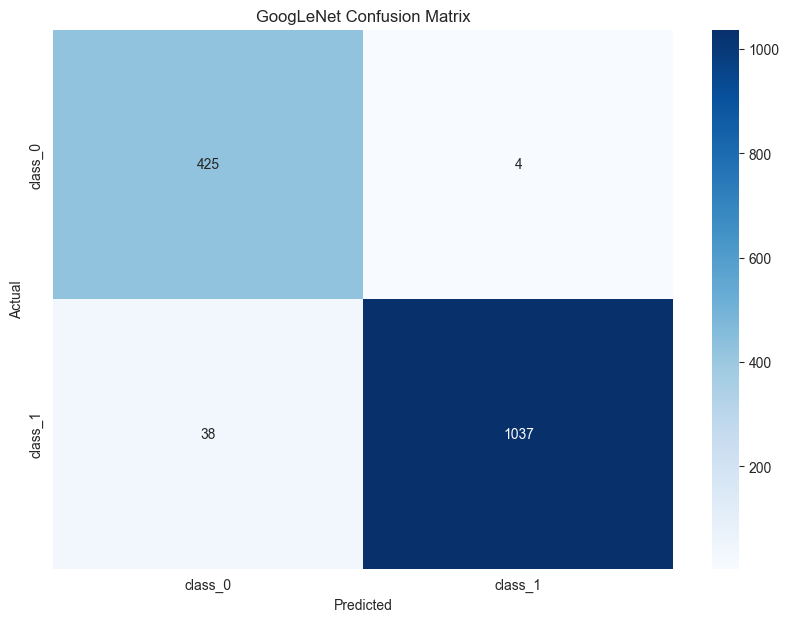

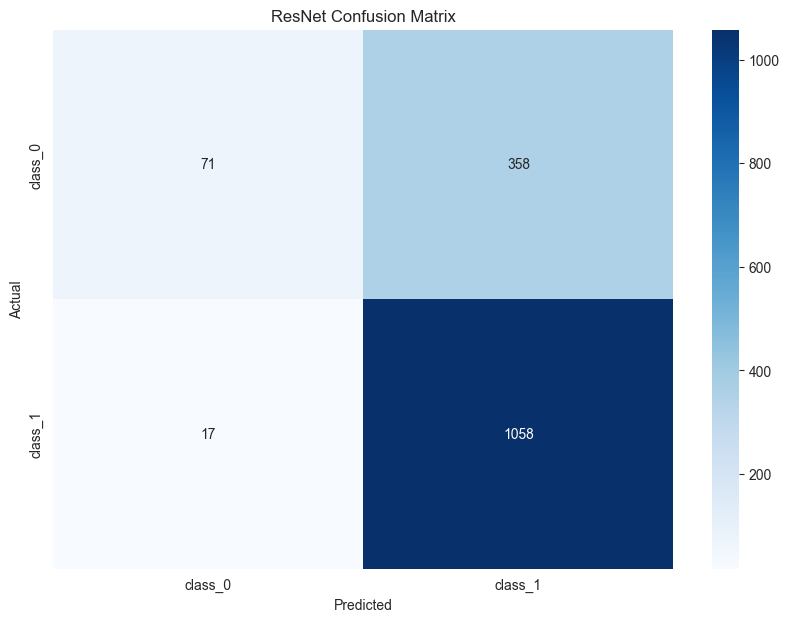

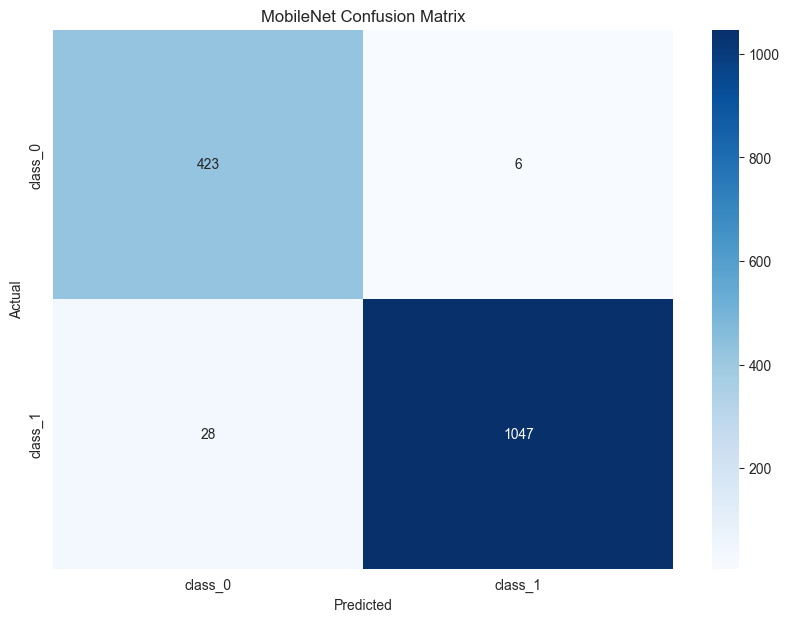

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Assuming conf_matrix_googlenet, conf_matrix_resnet, and conf_matrix_mobilenet are already defined

# Plot Confusion Matrices for all models
plot_confusion_matrix(conf_matrix_googlenet, class_names, title='GoogLeNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_resnet, class_names, title='ResNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_mobilenet, class_names, title='MobileNet Confusion Matrix')


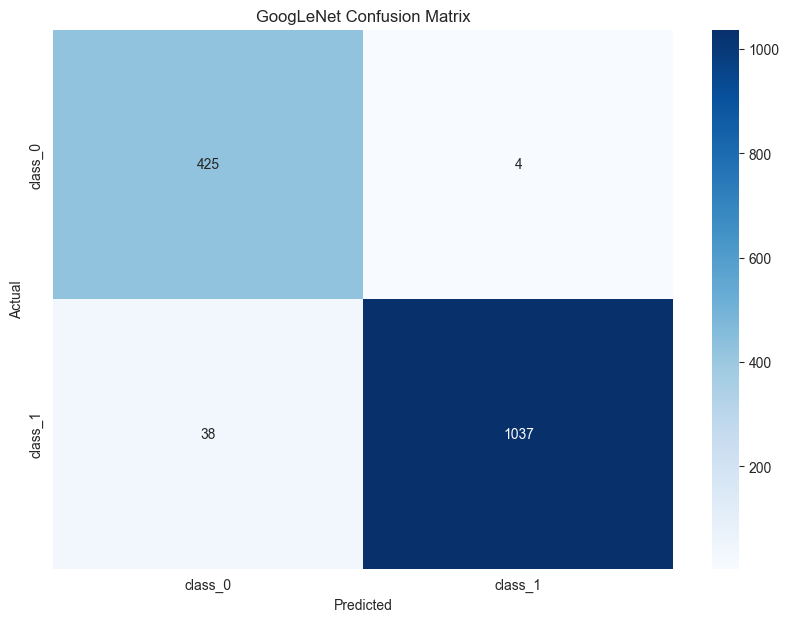

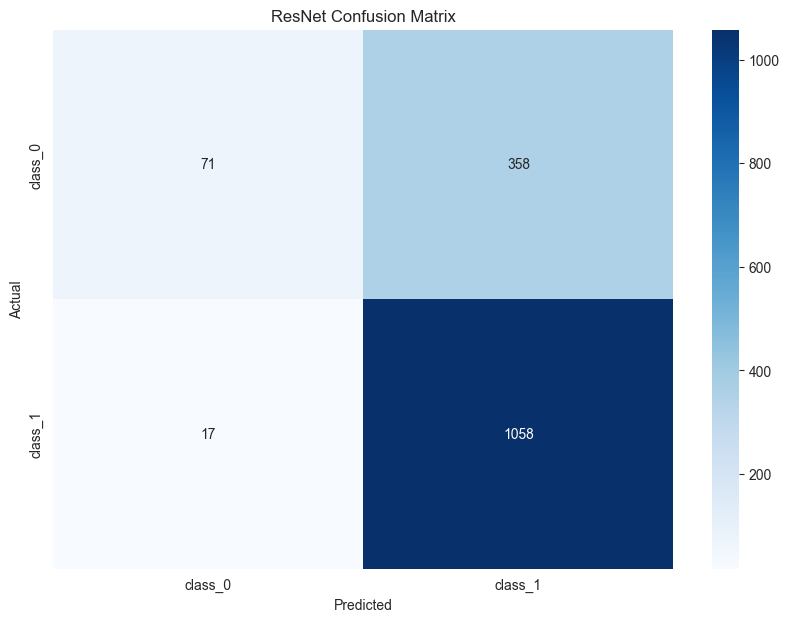

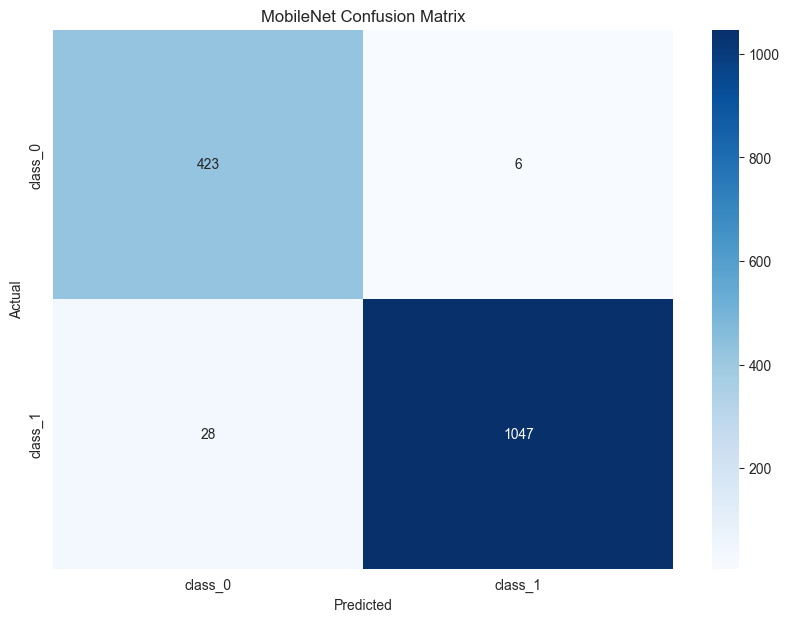

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Assuming class_names is defined as a list of class names
class_names = ['class_0', 'class_1']

# Plot Confusion Matrices for all models
plot_confusion_matrix(conf_matrix_googlenet, class_names, title='GoogLeNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_resnet, class_names, title='ResNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_mobilenet, class_names, title='MobileNet Confusion Matrix')


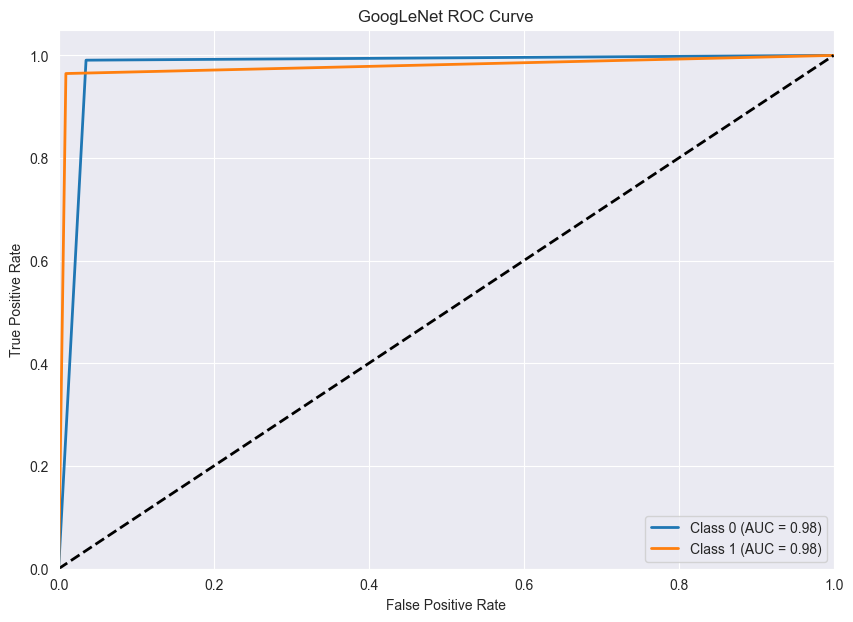

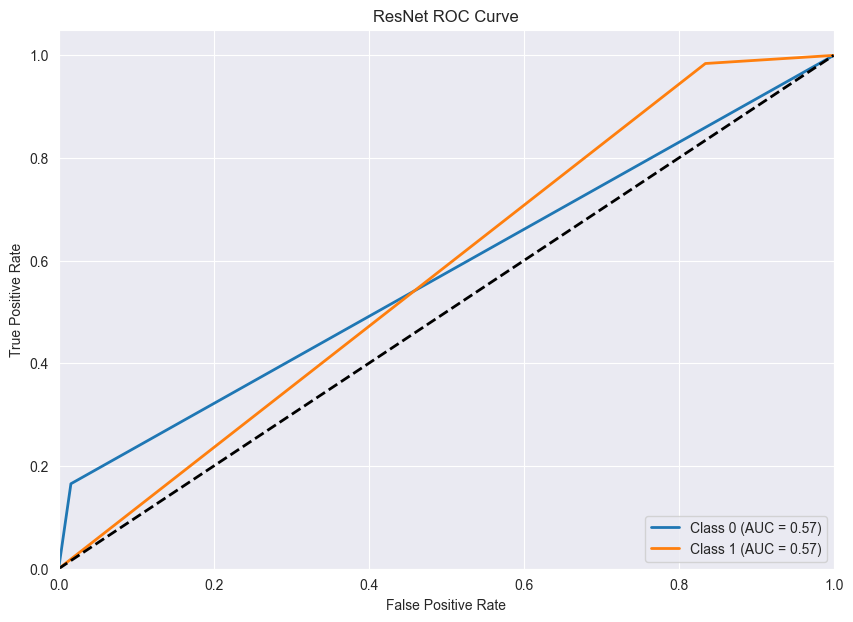

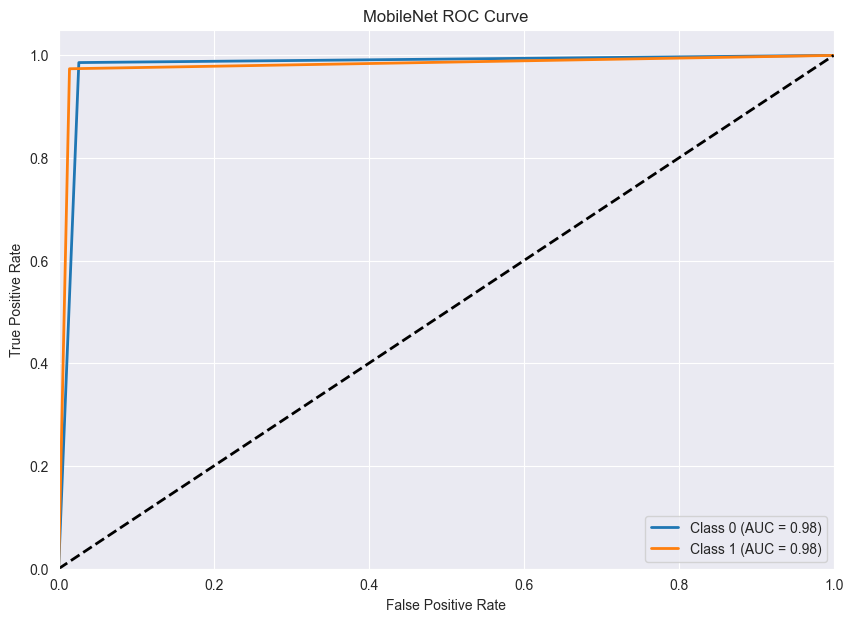

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_true, y_pred, n_classes, title='ROC Curve'):
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)
    plt.figure(figsize=(10, 7))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_true_googlenet, y_pred_googlenet, y_true_resnet, y_pred_resnet, y_true_mobilenet, y_pred_mobilenet are already defined

# Plot ROC Curves for all models
plot_roc_auc(y_true_googlenet, y_pred_googlenet, len(class_names), title='GoogLeNet ROC Curve')
plot_roc_auc(y_true_resnet, y_pred_resnet, len(class_names), title='ResNet ROC Curve')
plot_roc_auc(y_true_mobilenet, y_pred_mobilenet, len(class_names), title='MobileNet ROC Curve')



    Model  Precision  Recall  F1 Score  ROC AUC
GoogLeNet     0.9738  0.9721    0.9724   0.9777
   ResNet     0.7642  0.7507    0.6855   0.5748
MobileNet     0.9782  0.9774    0.9776   0.9800


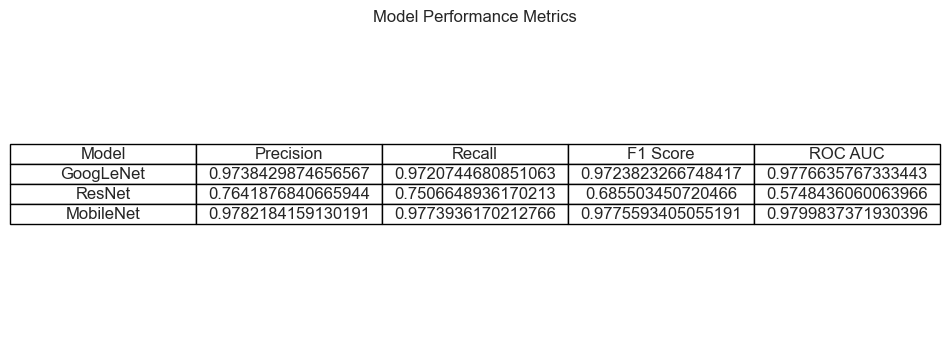

In [12]:
import pandas as pd

# Create DataFrame to display metrics
metrics_data = {
    'Model': ['GoogLeNet', 'ResNet', 'MobileNet'],
    'Precision': [precision_googlenet, precision_resnet, precision_mobilenet],
    'Recall': [recall_googlenet, recall_resnet, recall_mobilenet],
    'F1 Score': [f1_score_googlenet, f1_score_resnet, f1_score_mobilenet],
    'ROC AUC': [roc_auc_googlenet, roc_auc_resnet, roc_auc_mobilenet]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the table with precision to 4 decimal places
metrics_table = metrics_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x))

print(metrics_table)

# Plotting the table
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('Model Performance Metrics')
plt.show()


In [13]:
from tensorflow.keras.models import load_model
import numpy as np

# Load trained models
model_googlenet = load_model('traffic_model_googlenet.h5')
model_resnet = load_model('traffic_model_resnet.h5')
model_mobilenet = load_model('traffic_model_mobilenet.h5')

# Make predictions
def get_predictions_and_labels(model, generator):
    steps = generator.samples // generator.batch_size
    predictions = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes[:len(y_pred)]
    return y_true, y_pred

# Function to evaluate model performance
def evaluate_model_performance(y_true, y_pred):
    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)
    # Calculate precision, recall, F1-score, etc. (if needed)
    # Add additional evaluation metrics as required
    return accuracy

# Evaluate performance of GoogleNet model
y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
accuracy_googlenet = evaluate_model_performance(y_true_googlenet, y_pred_googlenet)

# Evaluate performance of ResNet model
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
accuracy_resnet = evaluate_model_performance(y_true_resnet, y_pred_resnet)

# Evaluate performance of MobileNet model
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)
accuracy_mobilenet = evaluate_model_performance(y_true_mobilenet, y_pred_mobilenet)

# Print model performance
print("GoogleNet Accuracy:", accuracy_googlenet)
print("ResNet Accuracy:", accuracy_resnet)
print("MobileNet Accuracy:", accuracy_mobilenet)


47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
GoogleNet Accuracy: 0.9720744680851063
ResNet Accuracy: 0.7506648936170213
MobileNet Accuracy: 0.9773936170212766


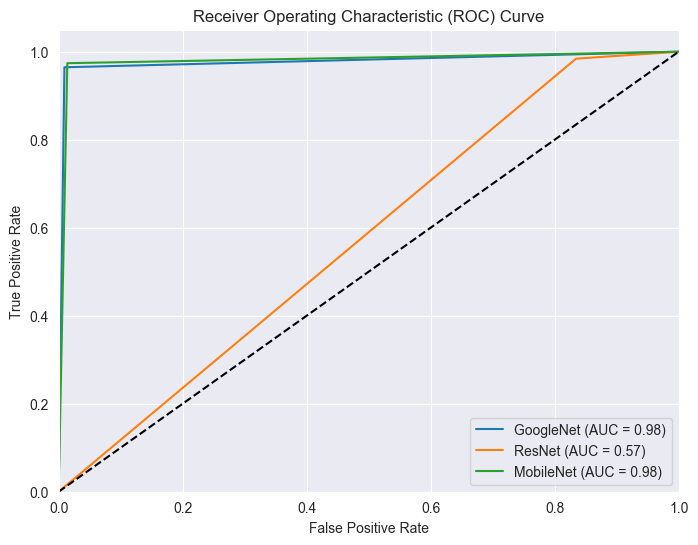

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate AUC for all models
def calculate_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Plot ROC curve
def plot_roc_curve(fprs, tprs, aucs, model_names):
    plt.figure(figsize=(8, 6))
    for i in range(len(model_names)):
        plt.plot(fprs[i], tprs[i], label=f'{model_names[i]} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Calculate AUC for GoogleNet
fpr_googlenet, tpr_googlenet, auc_googlenet = calculate_auc(y_true_googlenet, y_pred_googlenet)

# Calculate AUC for ResNet
fpr_resnet, tpr_resnet, auc_resnet = calculate_auc(y_true_resnet, y_pred_resnet)

# Calculate AUC for MobileNet
fpr_mobilenet, tpr_mobilenet, auc_mobilenet = calculate_auc(y_true_mobilenet, y_pred_mobilenet)

# Plot ROC curve for all models
plot_roc_curve([fpr_googlenet, fpr_resnet, fpr_mobilenet],
               [tpr_googlenet, tpr_resnet, tpr_mobilenet],
               [auc_googlenet, auc_resnet, auc_mobilenet],
               ['GoogleNet', 'ResNet', 'MobileNet'])


In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Parameters
input_shape = (224, 224, 3)
class_names = ['class_0', 'class_1']  # Update with actual class names
batch_size = 32  # Adjust according to your GPU memory

# Directories
train_dir = 'yolo format/cropped/train'
val_dir = 'yolo format/cropped/val'
test_dir = 'yolo format/cropped/test'

# Data Generators
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load Pre-trained ResNet50 Model and Modify It
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Apply Attention Mechanism
attention = Attention()  # Default parameters: use_scale=True, causal=False
x = attention([x, x])  # Apply attention mechanism to both query and value paths

predictions = Dense(len(class_names), activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model with Early Stopping
model_resnet.fit(train_generator, epochs=2, validation_data=val_generator, callbacks=[early_stopping])

# Save the Model
model_resnet.save('traffic_model_resnet_with_attention.h5')

# Evaluate the Model
evaluation_resnet = model_resnet.evaluate(test_generator)
print(f'ResNet Test loss: {evaluation_resnet[0]}, Test accuracy: {evaluation_resnet[1]}')


Found 4131 images belonging to 2 classes.
Found 1399 images belonging to 2 classes.
Found 1507 images belonging to 2 classes.
Epoch 1/2


ValueError: Exception encountered when calling Attention.call().

[1mDimension must be 2 but is 3 for '{{node functional_33_1/attention_14_1/transpose}} = Transpose[T=DT_HALF, Tperm=DT_INT32](functional_33_1/dense_47_1/Relu, functional_33_1/attention_14_1/transpose/perm)' with input shapes: [?,1024], [3].[0m

Arguments received by Attention.call():
  • inputs=['tf.Tensor(shape=(None, 1024), dtype=float16)', 'tf.Tensor(shape=(None, 1024), dtype=float16)']
  • mask=['None', 'None']
  • training=True
  • return_attention_scores=False
  • use_causal_mask=False